# Clustering de activos con Momentum

In [159]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

En este notebook vamos a intentar aplicar las técnicas de clustering que hemos visto a los mercados financieros. En concreto, vamos a utilizar los datos de **Yahoo finance** utilizando la librería `yfinance`. Concretamente, vamos a explorar qué sucede si intentamos hacer clustering exclusivamente con los valores de retorno logarítmico frente a hacer clustering utilizando otro tipo de indicadores, como el Momentum.

$$Momentum = {C_t \over C_{t-N}},$$

$$log(Momentum) = log(C_t) - log(C_{t-N}) = \sum_{i=0}^N r_{t-i},$$

donde $r_t = log(C_t) - log(C_{t-1})$.

Vamos a definir qué valores de Momentum queremos, además del retorno logarítmico (que podría interpretarse como `Momentum@1`):

In [ ]:
momentum_values = [5, 10, 20, 30, 40, 50]
lista_atributos = ["logRet"] + ["momentum@"+str(m) for m in momentum_values]

Nos definimos una función que extraiga la información que necesitamos a partir del OHLC de un activo.

In [ ]:
def preprocesar_activo(activo, start="2010-01-01"):
    # Por empezar en algún valor, guardamos siempre a partir del 1 de enero de 2010
    ohlc = yf.download(tickers=activo, start=start)

    # Calculamos los retornos logarítmicos
    ohlc["logRet"] = np.log(ohlc["Adj Close"]).diff()

    # Calculamos los momentums a distintas ventanas temporales
    for momentum in momentum_values:
        ohlc["momentum@"+str(momentum)] = ohlc["logRet"].rolling(momentum).sum()

    # Limpiamos los NaN
    ohlc.dropna(inplace = True)

    # Eliminamos el resto de atributos del dataset que no nos interesan
    datos = ohlc[lista_atributos]

    # Devolvemos el resultado en formato numpy para poder trabajarlos más cómodamente
    return datos.values, ohlc

Una vez tenemos esto, vamos a procesar una serie de activos. Para empezar, hagamos la primera prueba con solamente un activo, a ver si encontramos patrones de comportamiento similares a lo largo del tiempo.

In [ ]:
activos = ["AAPL"] # Añadir en esta lista los activos que uno quiera.
lista_vectores = []
for activo in activos:
    dataset, _ = preprocesar_activo(activo)
    lista_vectores.append(dataset)
dataset = np.concatenate(lista_vectores, axis=0)
print(dataset.shape)

[*********************100%%**********************]  1 of 1 completed

(3558, 7)


No olvidemos normalizar los datos, ya que diferentes momentums se pueden mover en rangos de valores diferentes. Estos valores de `means` y `stds` los utilizaremos también para los datos de test.

In [ ]:
means = dataset.mean(axis=0, keepdims=True)
stds = dataset.std(axis=0, keepdims=True)
dataset = (dataset - means) / stds

Veamos qué aspecto tiene realmente nuestro dataset.

In [ ]:
df = pd.DataFrame(dataset, columns=lista_atributos)
df.sample(5)

logRet  momentum@5  momentum@10  momentum@20  momentum@30  \
2055 -0.568100    0.036576     1.737392     0.399129     0.820463   
1213  0.008220    0.517938    -0.171537    -0.235424    -0.807623   
1390  0.404102   -0.597163     0.527526     1.033616    -0.217166   
1214 -1.461732    0.613473    -0.970568    -0.524470    -1.195555   
2524  2.844763    1.310440     0.586780    -0.987648    -2.781949   

      momentum@40  momentum@50  
2055     0.256785     0.084287  
1213    -0.149555     0.048759  
1390    -0.992732    -1.124092  
1214    -0.504528    -0.203284  
2524    -2.386103    -1.936458

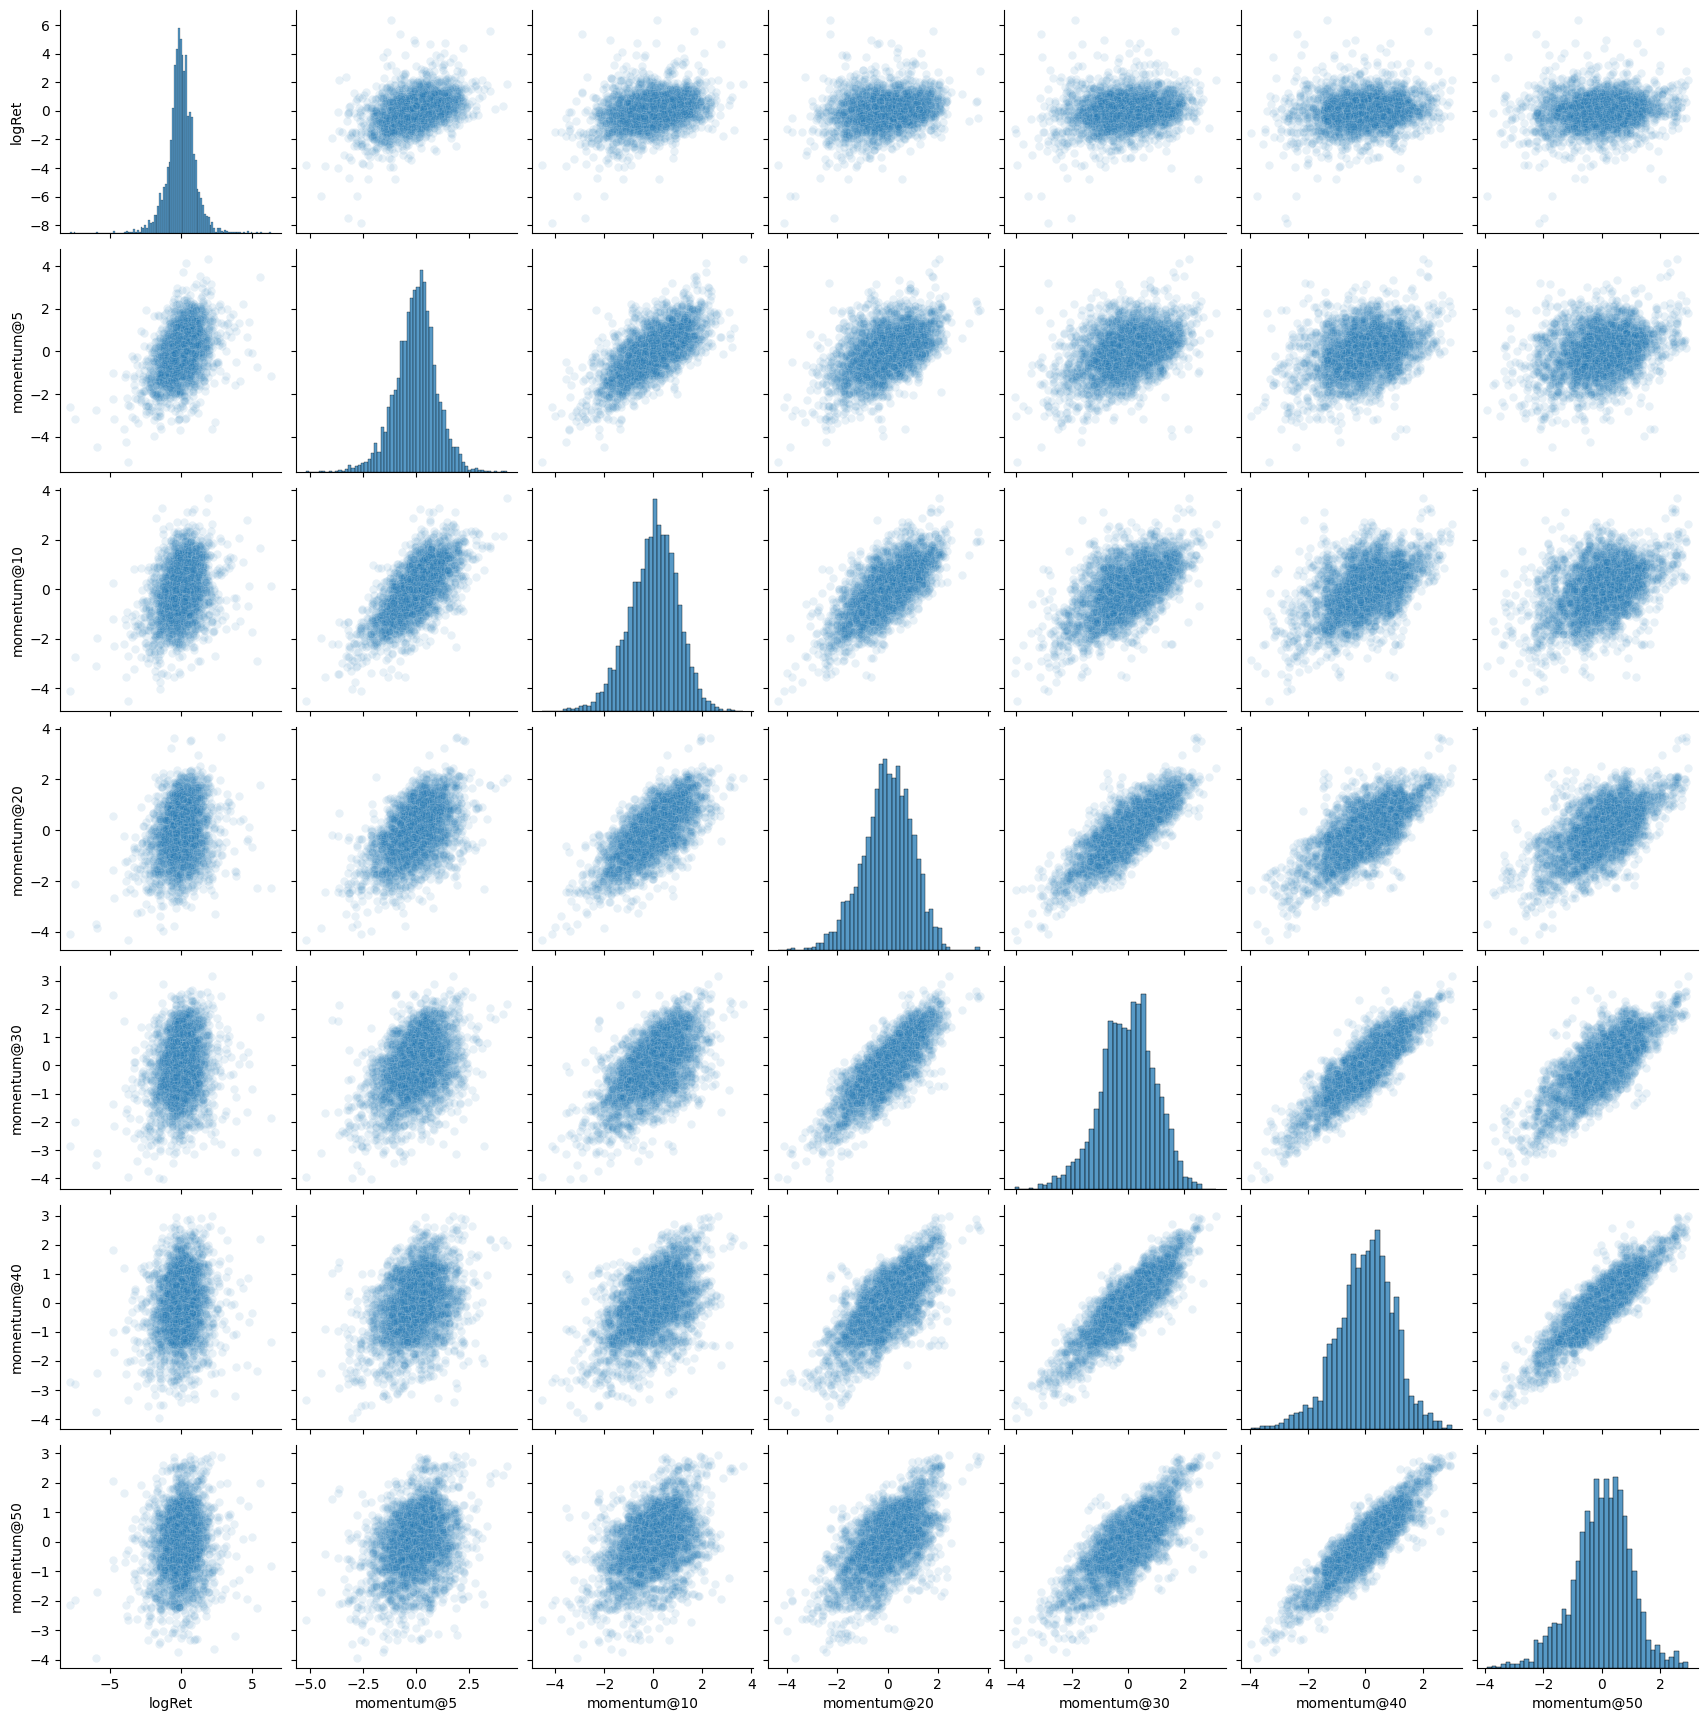

In [ ]:
sns.pairplot(df, kind='scatter', plot_kws={'alpha':0.1})
plt.show()

## Clustering

Con estos datos iniciales, vamos a intentar utilizar KMeans para clusterizar. Empecemos con un clustering de `K=2`.

In [ ]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset)
clusters = kmeans.predict(dataset)

Visualicemos ahora los dos clusters, a ver qué aspecto tienen los datos según el cluster al que pertenezca. Usemos un boxplot para ver mediana, cuartiles y outliers.

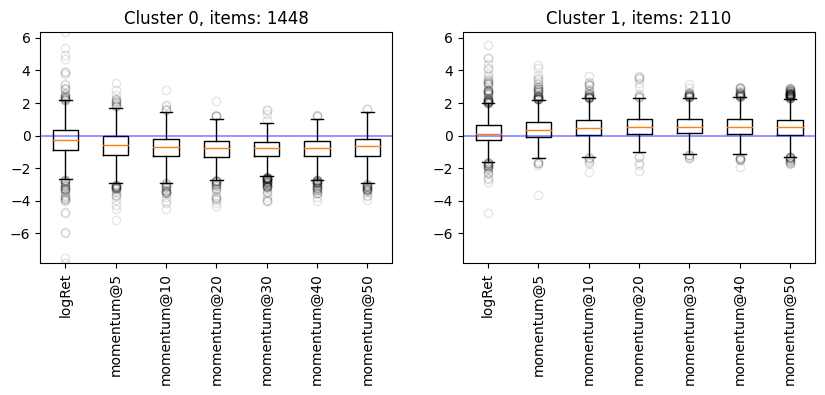

In [ ]:
plt.figure(figsize=(10, 3))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = dataset[indices]
    plt.subplot(1, 2, c+1)
    plt.boxplot(datos, flierprops={"alpha":0.1})
    plt.ylim(dataset.min(), dataset.max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.axhline(0.0, color="blue", alpha=0.4)
    plt.xticks(range(1, dataset.shape[1]+1), lista_atributos, rotation=90)
plt.show()

**Pregunta**: ¿Qué conclusiones podemos sacar de este resultado?

Intentemos visualizar los datos por cluster en el espacio de datos en el que estamos.

In [ ]:
df_clusters = pd.concat([df, pd.Series(clusters, name='cluster', index=df.index)], axis=1)
df_clusters.sample(5)

logRet  momentum@5  momentum@10  momentum@20  momentum@30  \
1404  0.043755   -0.006608     0.293594    -0.759905    -0.385128   
1632 -1.552637   -0.264344    -0.613805    -0.547720     0.023003   
22   -0.127743    0.394645     0.493396     1.148658     0.980267   
7     0.997115    0.885781     0.182116     1.345248     1.291501   
2096  0.036303    0.346722     0.410626    -0.206013    -0.045268   

      momentum@40  momentum@50  cluster  
1404    -0.766592    -0.823865        0  
1632     0.488762     0.649775        0  
22       1.509661     1.693557        1  
7        1.001377     0.372671        1  
2096    -0.188150     0.309520        1

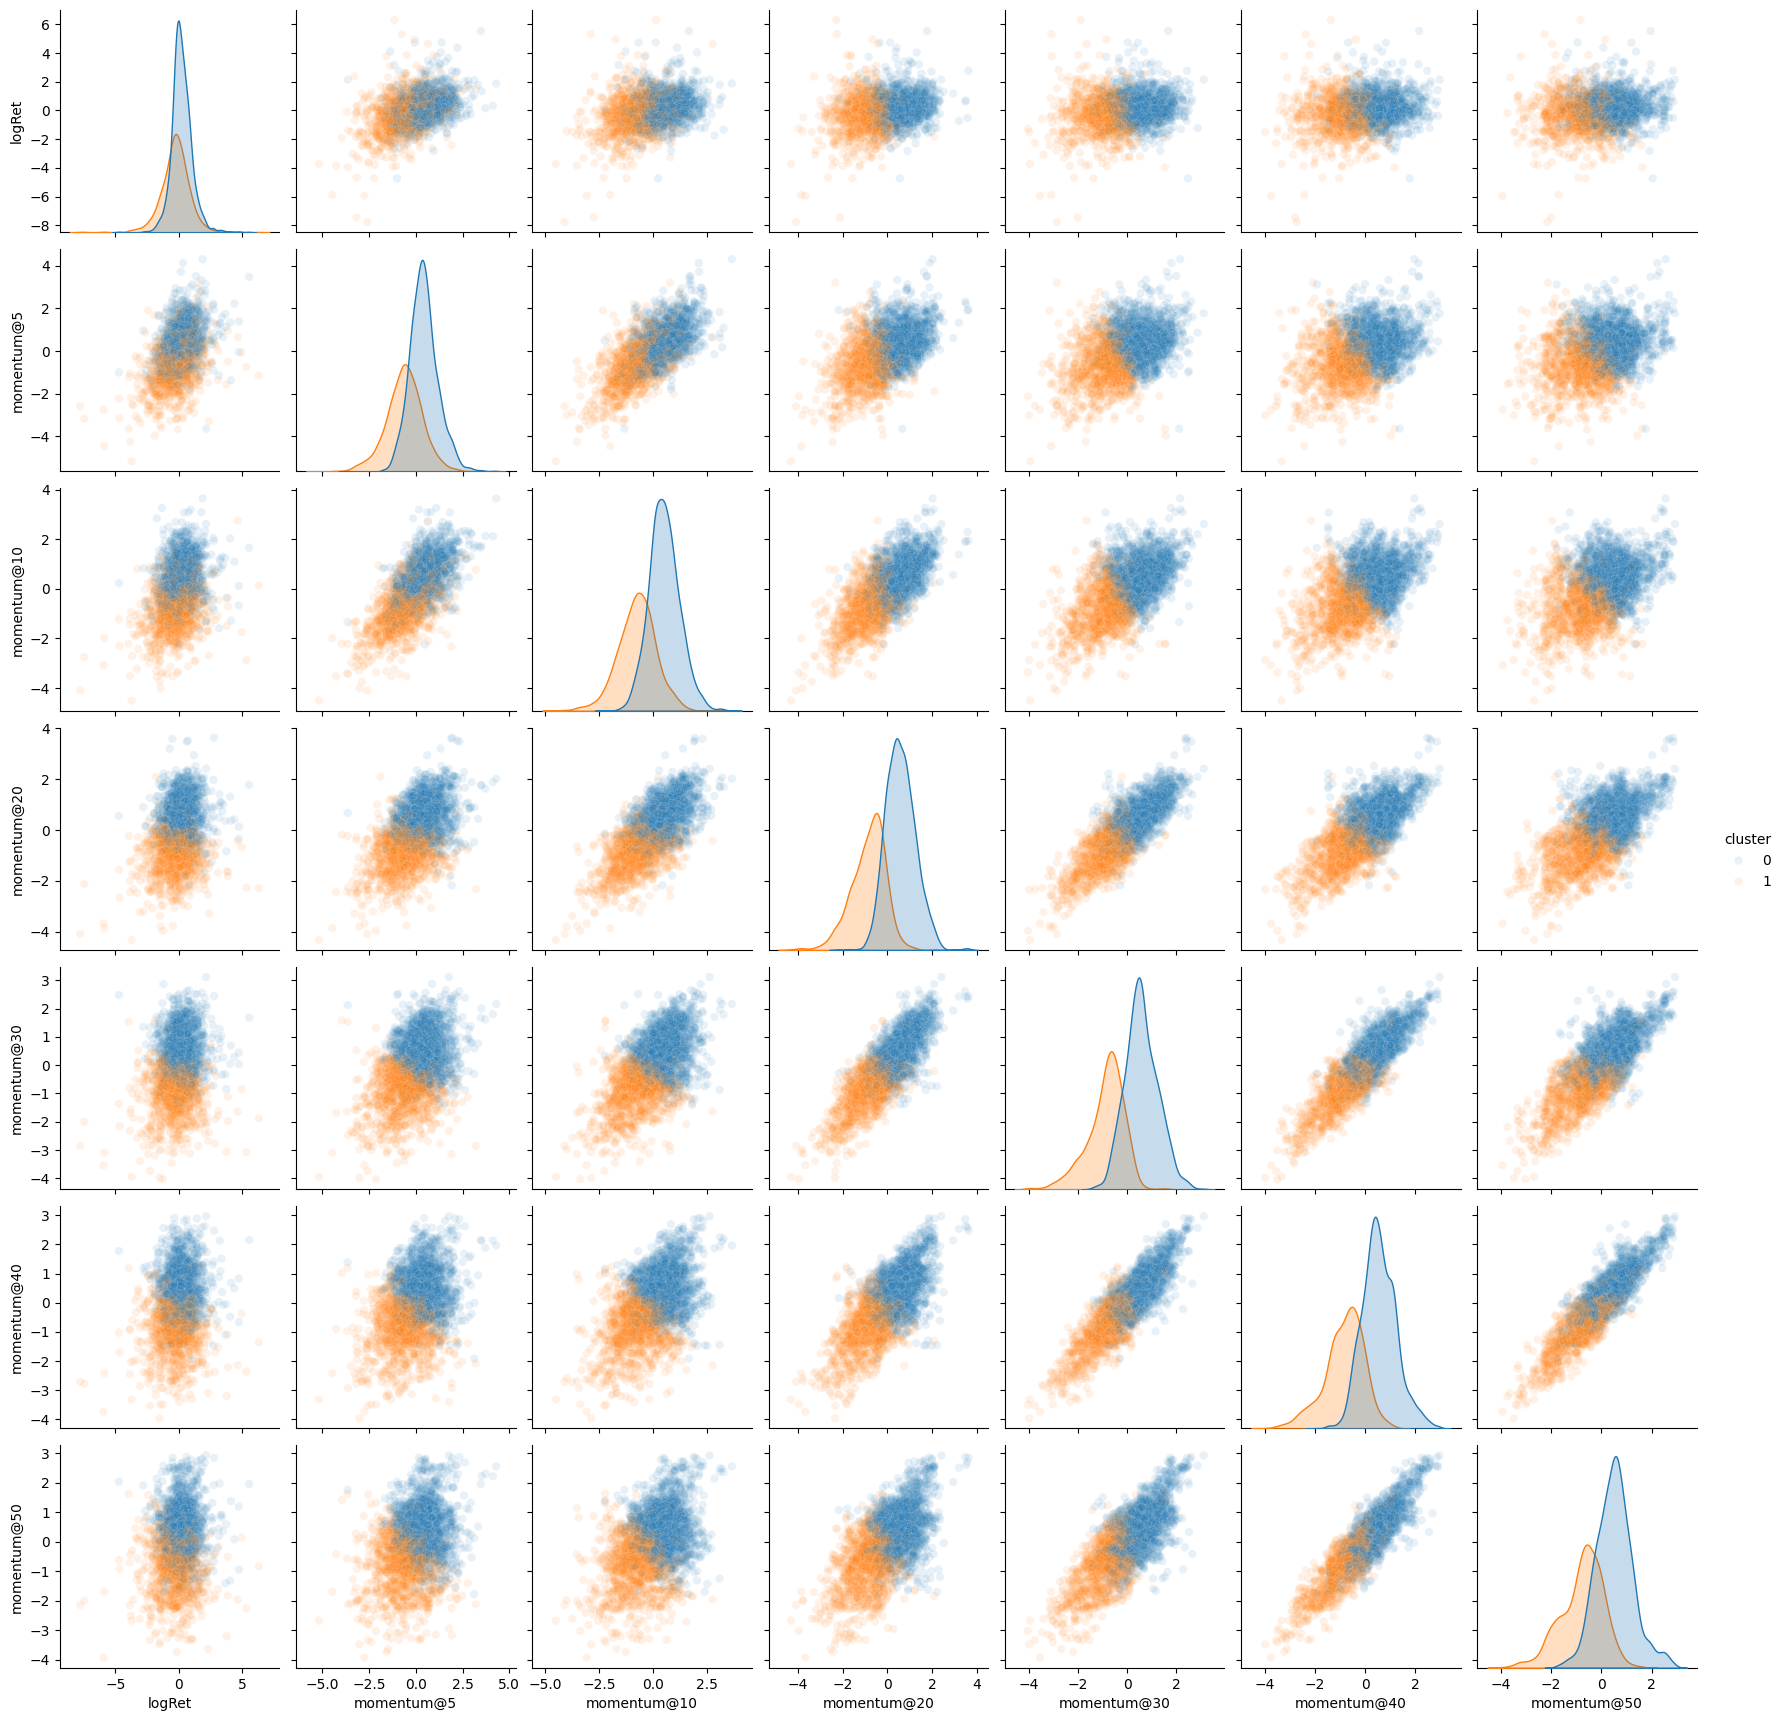

In [ ]:
sns.pairplot(df_clusters, hue="cluster", kind='scatter', plot_kws={'alpha':0.1})
plt.show()

Intentemos ahora analizar un valor de K mayor.

In [ ]:
n_clusters = 15 # Pon múltiplos de 3 para dibujar los patrones bien
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
kmeans.fit(dataset)
clusters = kmeans.predict(dataset)

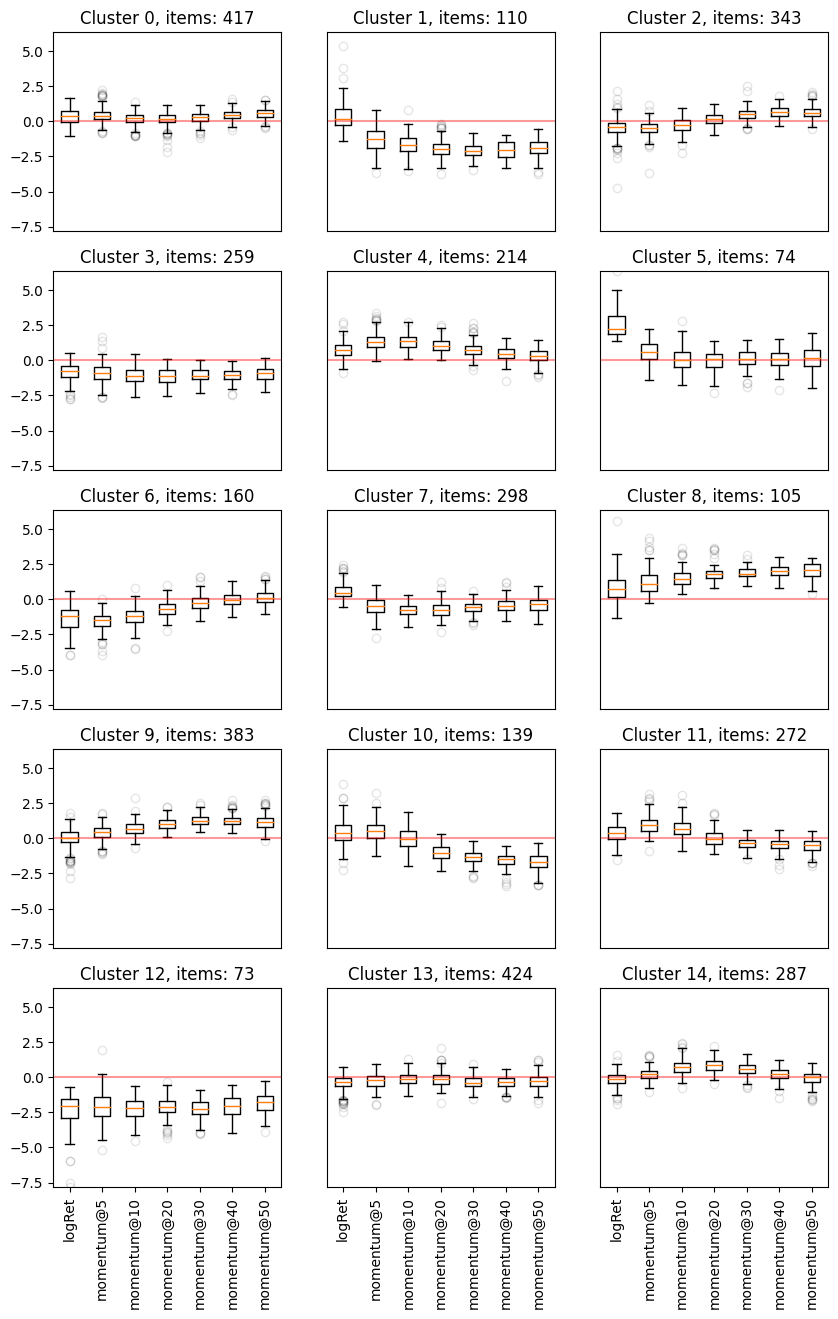

In [ ]:
filas = n_clusters // 3
columnas = n_clusters // filas
plt.figure(figsize=(10, 3*filas))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = dataset[indices]
    plt.subplot(filas, columnas, c+1)
    plt.boxplot(datos, flierprops={"alpha":0.1})
    plt.ylim(dataset.min(), dataset.max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.axhline(0.0, color="red", alpha=0.4)
    if c % columnas != 0:
        plt.yticks([])
    if c // columnas < filas-1:
        plt.xticks([])
    else:
        plt.xticks(range(1, dataset.shape[1]+1), lista_atributos, rotation=90)
plt.show()

Otra forma de visualizar estos clusters consiste en representar su comportamiento gráfico a lo largo del tiempo. Cada cluster marca una tendencia de comportamiento a 50 días hacia atrás.

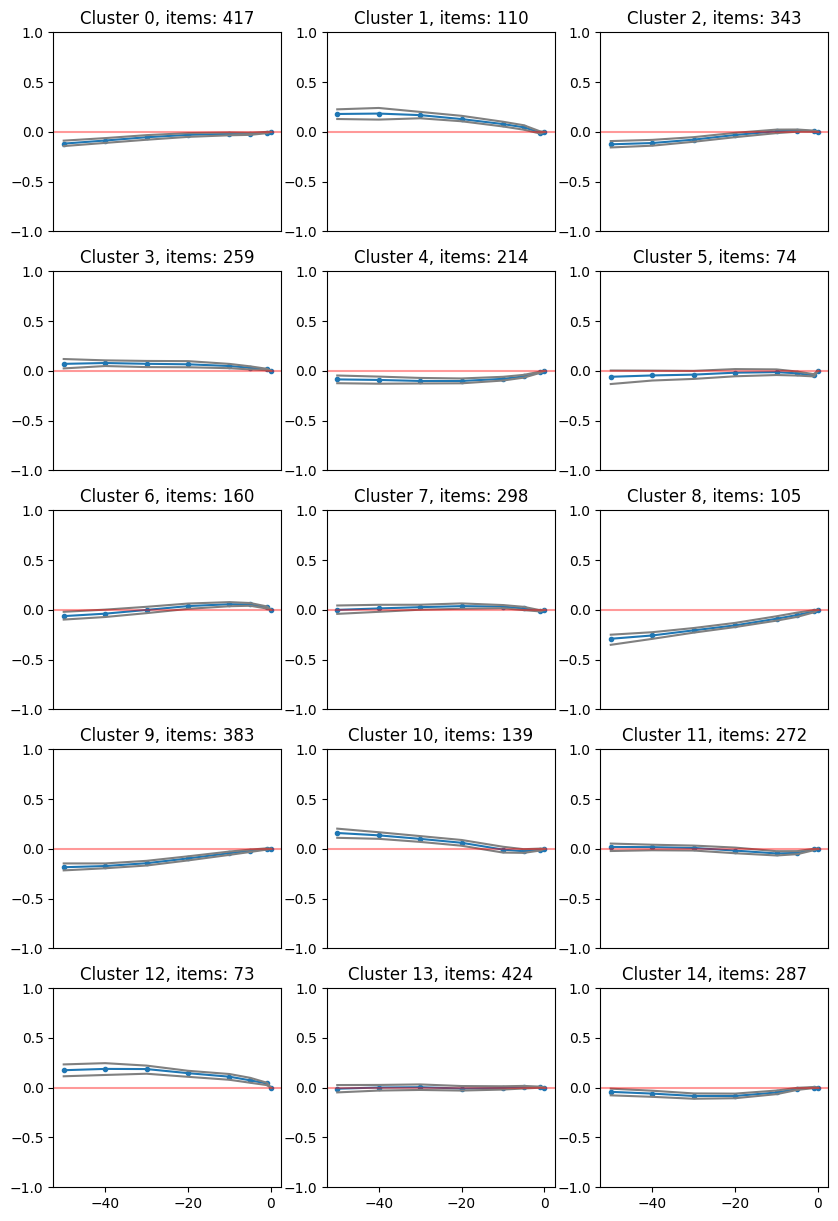

In [ ]:
times = np.array(momentum_values[::-1] + [1, 0]) * -1

filas = n_clusters // 3
columnas = n_clusters // filas
plt.figure(figsize=(10, 3*filas))
for c in range(n_clusters):
    indices = (clusters == c)
    datos = dataset[indices]
    plt.subplot(filas, columnas, c+1)
    medias = list(-(datos.mean(axis=0) * stds[0] + means[0])[::-1])
    q1 = list(-(np.percentile(datos, 25, axis=0) * stds[0] + means[0])[::-1])
    q3 = list(-(np.percentile(datos, 75, axis=0) * stds[0] + means[0])[::-1])
    plt.plot(times, medias + [0], '.-')
    plt.plot(times, q1 + [0], color="gray")
    plt.plot(times, q3 + [0], color="gray")
    #plt.ylim(dataset.min(), dataset.max())
    plt.title("Cluster "+str(c)+", items: "+str(indices.sum()))
    plt.ylim(-1.0, 1.0)
    if c // columnas < filas-1:
        plt.xticks([])
    plt.axhline(0.0, color="red", alpha=0.4)
plt.show()

**Pregunta** ¿Qué conclusiones podemos sacar de este resultado?

Visualicemos de nuevo con los clusters formados.

In [ ]:
df_clusters = pd.concat([df, pd.Series(clusters, name='cluster', index=df.index)], axis=1)
df_clusters.sample(5)

logRet  momentum@5  momentum@10  momentum@20  momentum@30  \
2675  1.986820   -0.222062    -1.031484    -0.416467     0.157841   
2019 -1.367728   -2.121621    -1.808567    -1.061067     0.379170   
2432 -0.105018    0.440747     1.259836     1.187623     1.339951   
2036 -0.179648    0.682198     0.488518    -0.058942    -0.235713   
14    0.193986    0.397100     0.797837     0.739077     1.787711   

      momentum@40  momentum@50  cluster  
2675    -1.533333    -0.425850        9  
2019    -0.647092    -0.817407        4  
2432     1.227561     1.610286        6  
2036    -0.041180     0.684561        5  
14       1.592220     0.993305        6

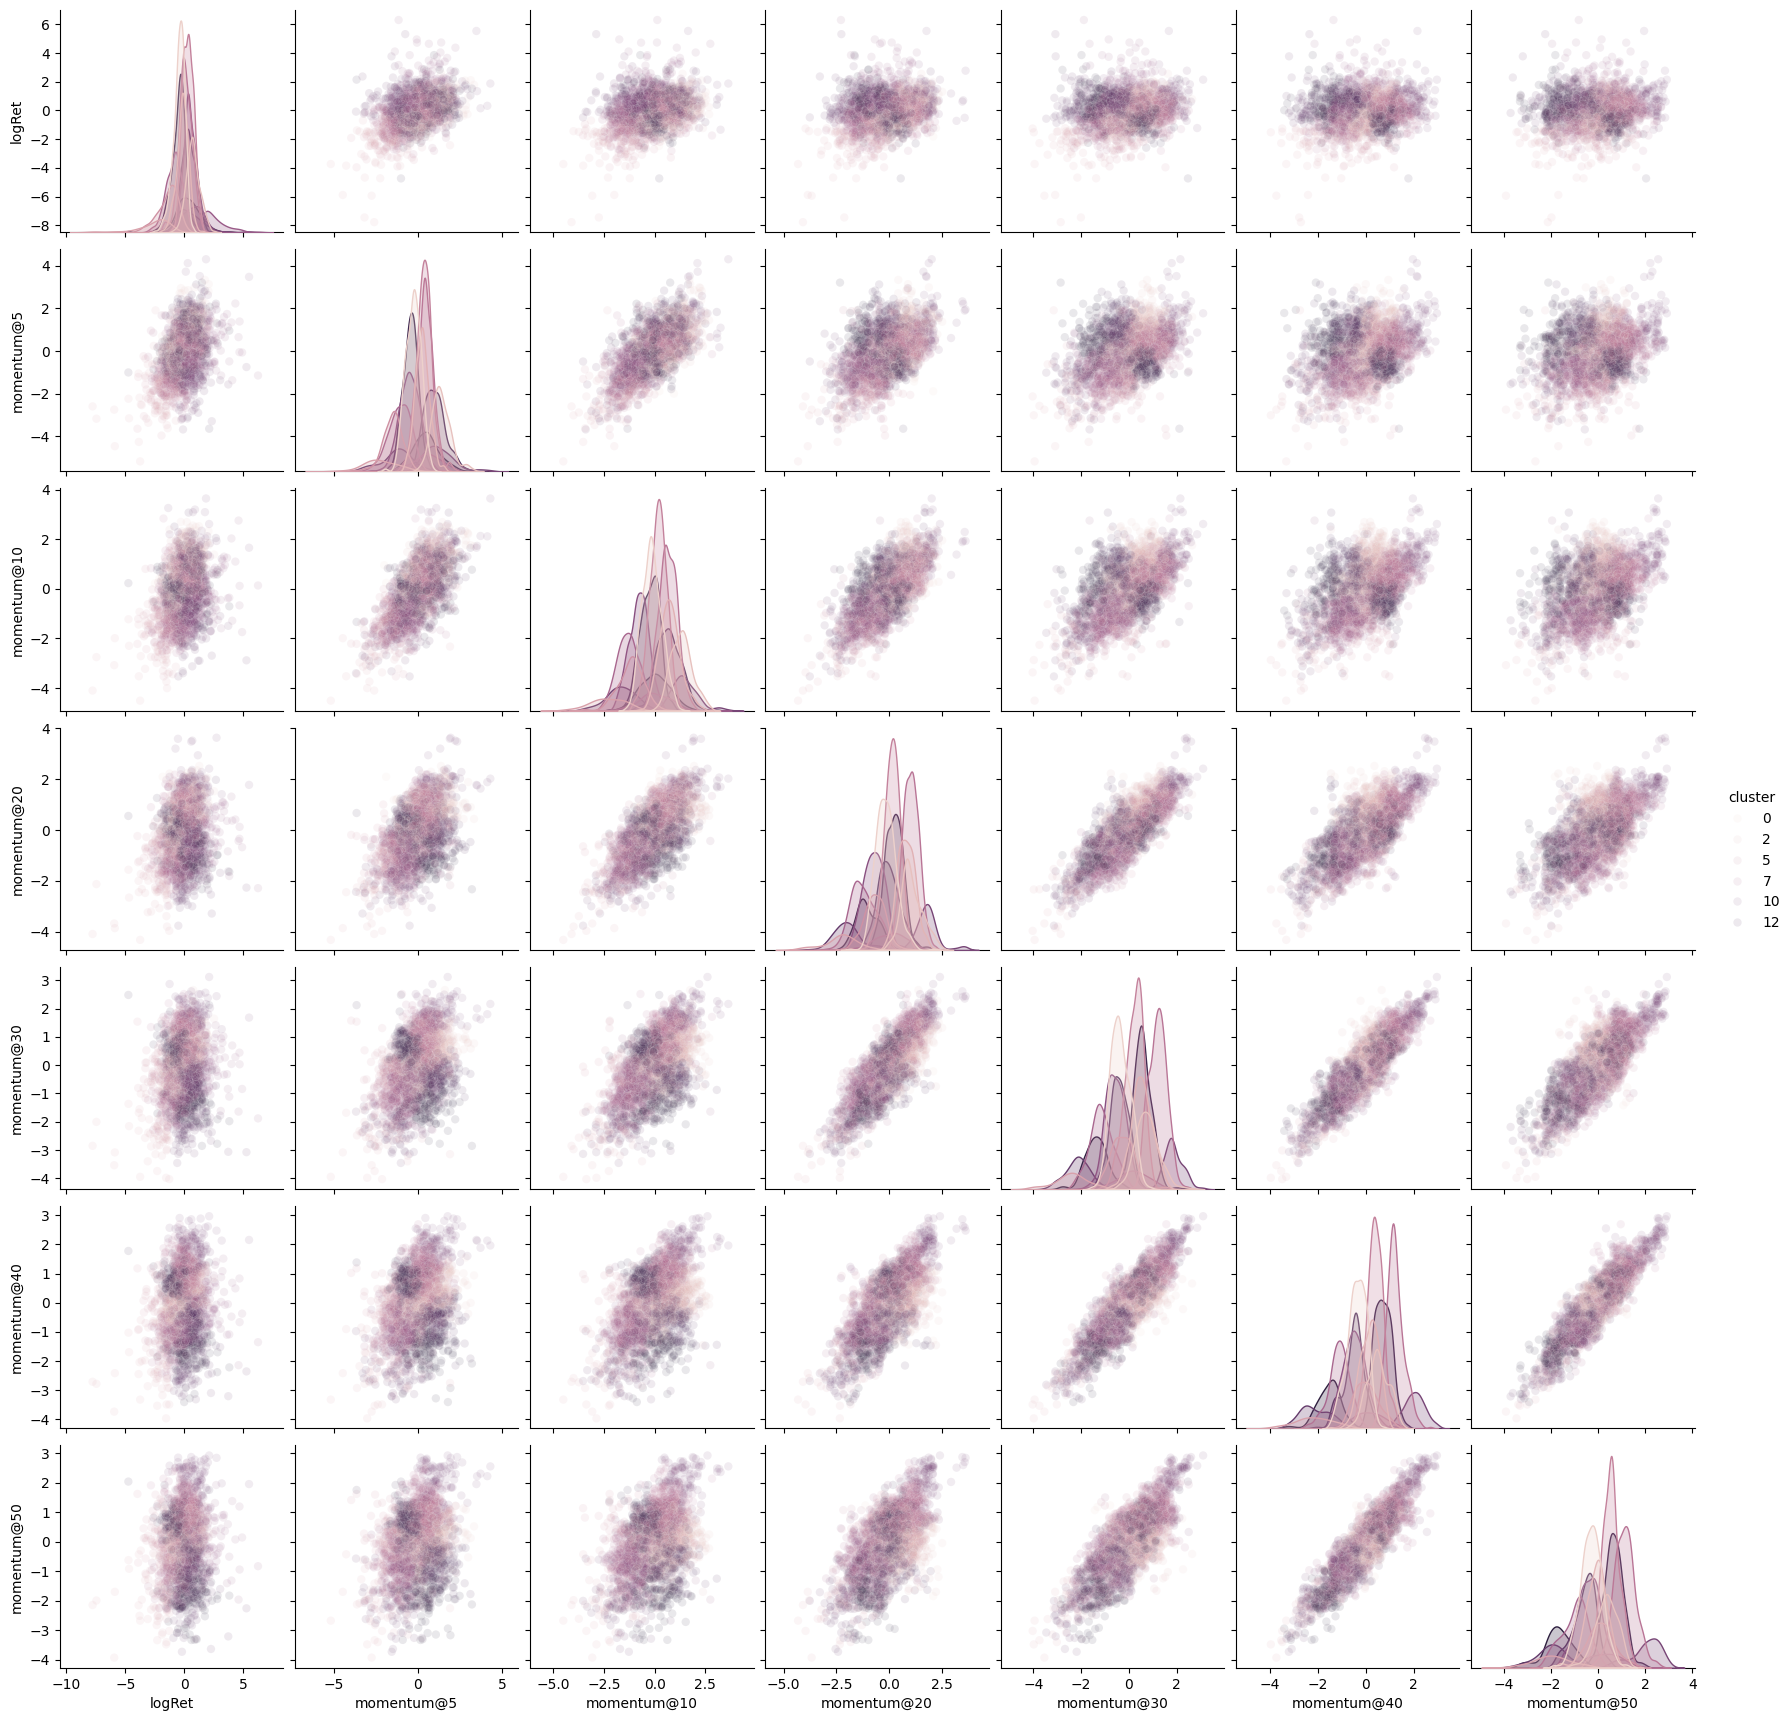

In [ ]:
sns.pairplot(df_clusters, hue="cluster", kind='scatter', plot_kws={'alpha':0.1})
plt.show()

## Transformar OHLC a vector de características

Si tenemos un algoritmo de clustering entrenado, como KMeans, una idea que se nos podría ocurrir es la siguiente: **¿puedo contar en un activo determinado cuántas veces aparezco en cada cluster a lo largo del tiempo?** Y si puedo hacerlo, **¿podría decir que la frecuencia de aparición en estos clusters define también el comportamiento de mi activo en toda su existencia?**

Probemos estas cosas con `TSLA`, un activo que no hemos utilizado en el conjunto de activos para hacer clustering.

In [ ]:
datos_test, ohlc = preprocesar_activo("TSLA")
datos_test = (datos_test - means) / stds # Recuerda normalizar los datos con las medias y stds de "los datos conocidos"
clusters_test = kmeans.predict(datos_test)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Contemos cuántas veces el Kmeans agrupa el activo en cada cluster a lo largo del tiempo
vector = np.zeros(n_clusters)
for c in clusters_test:
    vector[c] += 1

# Deberíamos normalizar el vector para compararlo con otros activos. No es necesario ahora
# vector = vector / vector.sum()

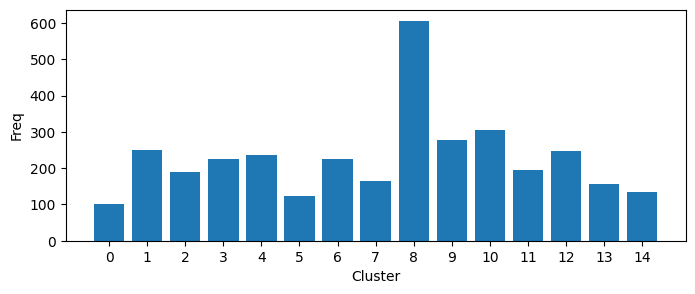

In [ ]:
plt.figure(figsize=(8, 3))
plt.bar(range(n_clusters), vector)
plt.xticks(range(n_clusters))
plt.xlabel("Cluster")
plt.ylabel("Freq")
plt.show()

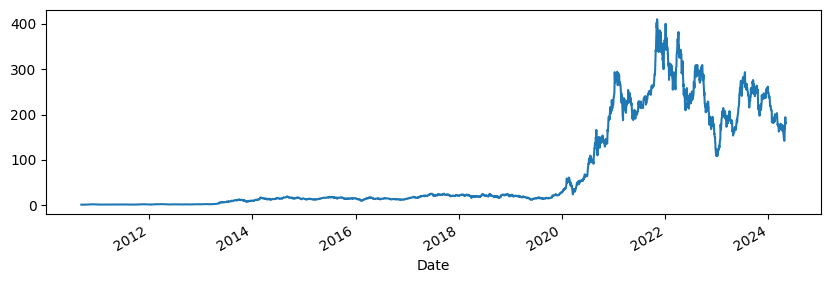

In [ ]:
ohlc["Adj Close"].plot(figsize=(10, 3))
plt.show()

**Discusión**: ¿Qué podemos deducir de estas figuras?

## Ejercicio

Siguiendo la estrategia anterior y asumiendo que el vector de frecuencias del cluster de momentums representa la serie temporal de un activo a lo largo de una ventana, se plantea el siguiente ejercicio:

- Haz la transformación a vector de características de cada activo de la siguiente lista con los datos a partir del 1 de enero de 2020.

- Con esos vectores de características, aplica algún algoritmo de clustering para encontrar activos similares.

- Visualiza los activos mediante una proyección a dos dimensiones utilizando PCA.

In [ ]:
lista_activos = ['A', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADM', 'ADSK',
                 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AKAM', 'ALL', 'ALLE',
                 'AMAT', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AON', 'APA', 'APD',
                 'APH', 'APTV', 'AVB', 'AVGO', 'AVY', 'AXP', 'AZO', 'BA', 'BAC',
                 'BALL', 'BAX', 'BBWI', 'BBY', 'BDX', 'BEN', 'BK', 'BKNG',
                 'BLK', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH',
                 'CAT', 'CB', 'CBRE', 'CCI', 'CCL', 'CF', 'CHRW', 'CI', 'CINF',
                 'CL', 'CLX', 'CMA', 'CMCSA', 'CMG', 'CMI', 'CMS', 'CNP', 'COF',
                 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CTAS', 'CTRA', 'CTSH',
                 'CVS', 'CVX', 'D', 'DAL', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR',
                 'DIS', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'EA', 'EBAY',
                 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'ELV', 'EMN', 'EMR', 'EOG', 'EQR',
                 'EQT', 'ES', 'ESS', 'ETN', 'ETR', 'EW', 'EXC', 'EXPD', 'EXPE', 'F',
                 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FI', 'FIS', 'FITB', 'FMC',
                 'FSLR', 'GD', 'GE', 'GEN', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GOOG',
                 'GOOGL', 'GPC', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HD', 'HES', 'HIG',
                 'HON', 'HPQ', 'HRL', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IFF', 'INTC',
                 'INTU', 'IP', 'IPG', 'IRM', 'ISRG', 'ITW', 'IVZ', 'JCI', 'JNJ',
                 'JNPR', 'JPM', 'K', 'KDP', 'KEY', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX',
                 'KO', 'KR', 'L', 'LDOS', 'LEN', 'LH', 'LHX', 'LLY', 'LMT', 'LNC',
                 'LOW', 'LRCX', 'LUV', 'LYB', 'MA', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO',
                 'MDT', 'MET', 'META', 'MHK', 'MKC', 'MLM', 'MMC', 'MMM', 'MO', 'MOS',
                 'MPC', 'MRK', 'MRO', 'MS', 'MSFT', 'MSI', 'MTB', 'NDAQ', 'NEE', 'NEM',
                 'NFLX', 'NI', 'NKE', 'NOC', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE',
                 'NVDA', 'NWL', 'NWSA', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OXY', 'PARA',
                 'PAYX', 'PCAR', 'PCG', 'PEAK', 'PEG', 'PFE', 'PG', 'PGR', 'PH', 'PHM',
                 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRU', 'PSA', 'PSX',
                 'PTC', 'PWR', 'PXD', 'QCOM', 'RCL', 'RF', 'RHI', 'RL', 'ROK', 'ROP',
                 'ROST', 'RSG', 'RTX', 'RVTY', 'SBUX', 'SCHW', 'SEE', 'SHW', 'SJM',
                 'SLB', 'SNA', 'SO', 'SPG', 'SPGI', 'SRE', 'STT', 'STX', 'STZ', 'SWK',
                 'SYK', 'SYY', 'T', 'TAP', 'TEL', 'TFC', 'TGT', 'TJX', 'TMO', 'TPR',
                 'TROW', 'TRV', 'TSCO', 'TSN', 'TT', 'TXT', 'UHS', 'UNH', 'UNP', 'UPS',
                 'URI', 'USB', 'V', 'VFC', 'VLO', 'VMC', 'VRSN', 'VTR', 'VZ', 'WAT',
                 'WEC', 'WELL', 'WFC', 'WHR', 'WM', 'WMB', 'WMT', 'WY', 'WYNN', 'XOM',
                 'XRAY', 'XYL', 'YUM', 'ZBH', 'ZION', 'ZTS']

In [ ]:
precios = yf.download(lista_activos, start="2020-01-01")["Adj Close"]
retornos = np.log(precios).diff().dropna()

[*********************100%%**********************]  327 of 327 completed


In [ ]:
vectores = []
for activo in lista_activos:
  datos_test, ohlc = preprocesar_activo(activo, start="2020-01-01")
  datos_test = (datos_test - means) / stds # Recuerda normalizar los datos con las medias y stds de "los datos conocidos"
  clusters_test = kmeans.predict(datos_test)

  # Contemos cuántas veces el Kmeans agrupa el activo en cada cluster a lo largo del tiempo
  vector = np.zeros(n_clusters)
  for c in clusters_test:
    vector[c] += 1

  # Deberíamos normalizar el vector para compararlo con otros activos. No es necesario ahora
  vector = vector / vector.sum()

  vectores.append(vector)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
vectores = np.array(vectores)
vectores.shape

(327, 15)

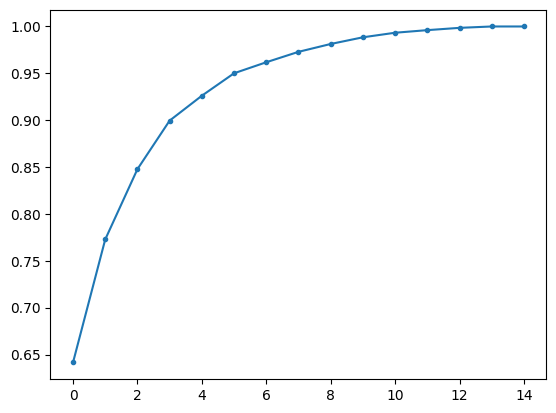

In [ ]:
pca = PCA(n_components=vectores.shape[1])
pca.fit(vectores)
plt.plot(pca.explained_variance_ratio_.cumsum(), '.-')
plt.show()

In [ ]:
pca = PCA(n_components=2)
vect_pca = pca.fit_transform(vectores)

In [ ]:
K = 5
kmeans_ejercicio = KMeans(n_clusters=K, n_init=10)
clusters = kmeans_ejercicio.fit_predict(vectores)

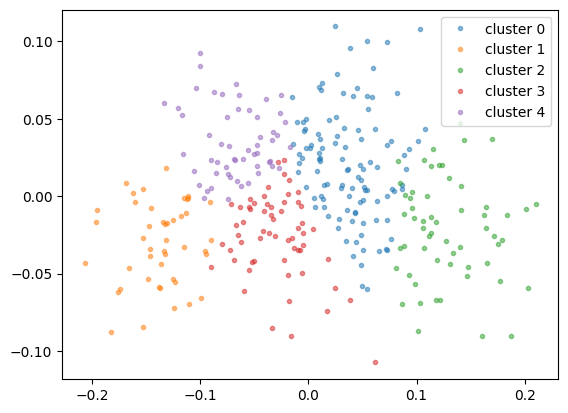

In [ ]:
for cluster in np.unique(clusters):
  plt.plot(vect_pca[clusters==cluster, 0], vect_pca[clusters==cluster, 1], '.', alpha=0.5, label="cluster "+str(cluster))
plt.legend()
plt.show()

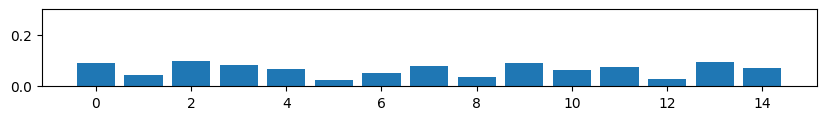

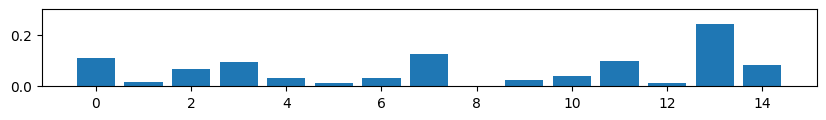

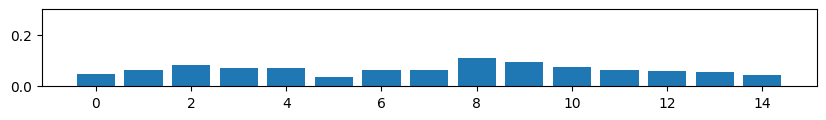

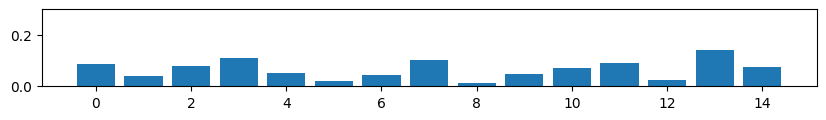

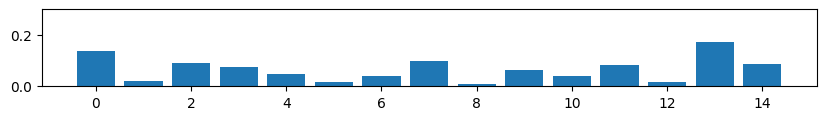

In [ ]:
for cluster in np.unique(clusters):
  representante = vectores[clusters==cluster].mean(axis=0)
  plt.figure(figsize=(10, 1))
  plt.bar(range(15), representante)
  plt.ylim(0.0, 0.3)
  plt.show()

**Discusión de los resultados**: ¿Qué podríamos hacer con estos vectores clusterizados?

## Interpretando el clustering de vectores de características usando árboles de decisión

Algo que podemos hacer para interpretar los resultados que obtenemos con el clustering es utilizar un árbol de decisión para aprender a predecir el cluster que está generando nuestro algoritmo de clustering. Al fin y al cabo, podemos utilizar la variable `vectores` como `X` y, por otro lado, la variable `clusters` como `target`.

In [158]:
print(vectores.shape, clusters.shape)

(327, 15) (327,)


In [181]:
# Con un arbol con máxima profundidad 3 soy capaz de explicar un 89% de la clusterización
# (en mi ejecución, esto puede variar)

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(vectores, clusters)
tree.score(vectores, clusters)

0.8899082568807339

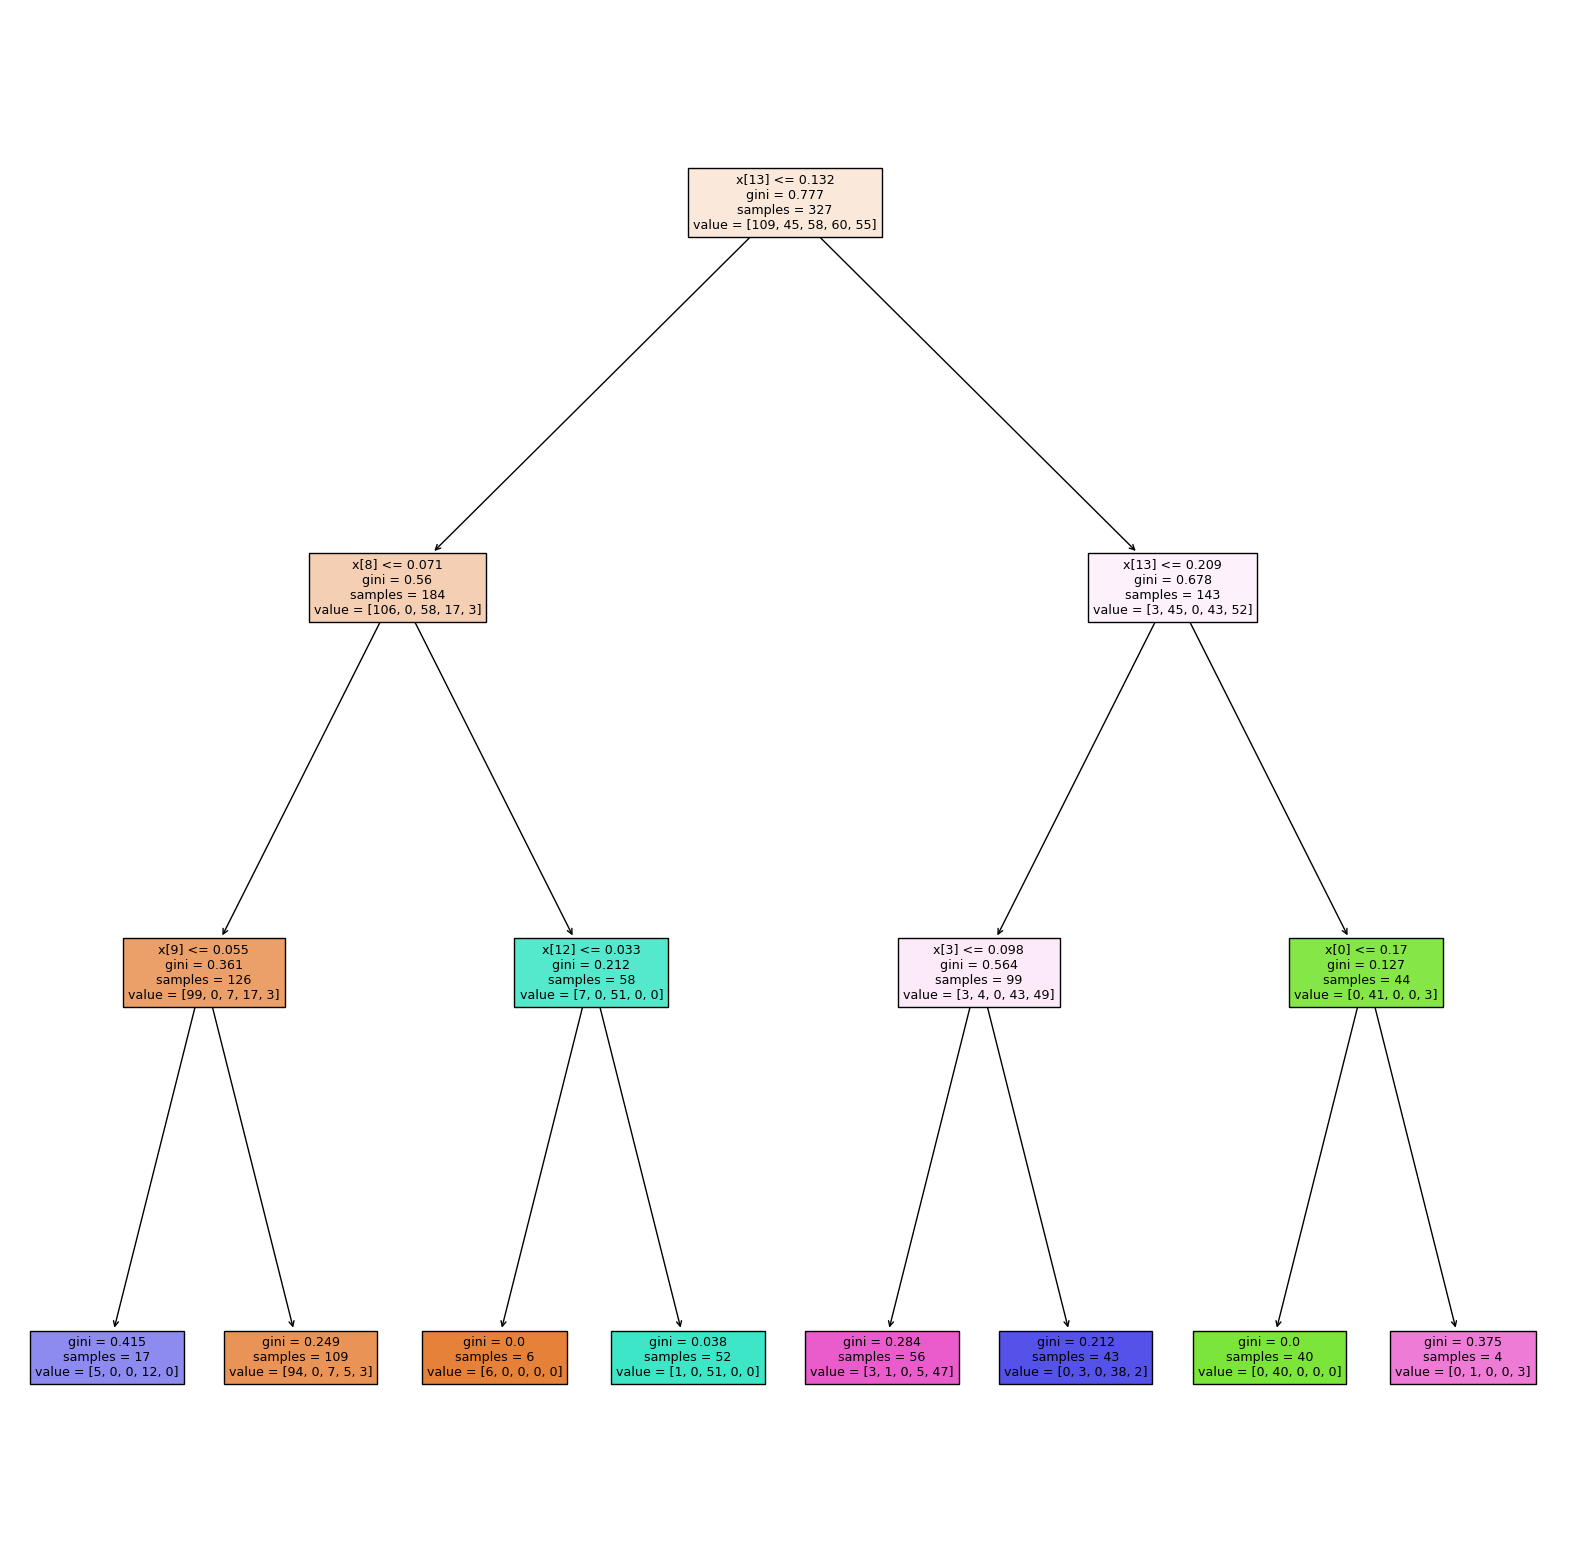

In [182]:
# Además, soy capaz de separar en los 5 clusters preguntando exclusivamente por 6 de las
# 15 componentes que tiene nuestro vector [13, 8, 9, 12, 3, 0]
# (en mi ejecución, esto puede variar)
plt.figure(figsize=(20,20))
plot_tree(tree, filled=True)
plt.show()

**Discusión de los resultados**: Con un árbol de decisión puedo explicar fácilmente dónde se está fijando el algoritmo de clustering para agrupar. Ya solo nos quedaría entender qué son las componentes mencionadas previamente para explicar el clustering completamente.